In [302]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# This module contains utility functions for the notebook exercises.

def plot_mesh(dx, N, figsize=None, display_fluxes = True, display_bc = True):
    """Plot a 1D mesh with N cells of size dx, including diffusive flux arrows at faces.
    Parameters:
    - dx: cell size (float)
    - N: number of cells (int)
    - figsize: figure size (tuple), optional
    - display_fluxes: whether to display internal flux arrows (bool), default True
    - display_bc: whether to display boundary flux arrows (bool), default True
    """

    if figsize is None:
        figsize = (N, 1)

    fig, ax = plt.subplots(figsize=figsize)
    for i in range(N):
        x0 = i * dx
        rect = Rectangle((x0, 0), dx, 1.0, facecolor='#e6eef7', edgecolor='k', linewidth=1.0)
        ax.add_patch(rect)
        ax.text(x0 + dx / 2, 0.5, r'$u_{%d}$' % i, ha='center', va='center')

    # Draw diffusive flux arrows at faces (including Neumann BC at boundaries)
    y_flux = 0.5
    span = 0.3 * dx  # arrow length across a face

    if display_fluxes:
        # Internal faces: i = 1..N-1
        for i in range(1, N):
            x_face = i * dx
            ax.annotate(
                '', xy=(x_face + span / 2, y_flux), xytext=(x_face - span / 2, y_flux),
                arrowprops=dict(arrowstyle='->', color='tab:purple', lw=1.2)
            )
            ax.text(x_face+ 0.01, y_flux + 0.1, r'$F_{%d}$' % i, ha='center', va='bottom', color='tab:purple')

    if display_bc:
        # Left boundary (Neumann BC): F[0], outward normal to the left
        left_shift = 0.2 * dx
        ax.annotate(
            '', xy=(0.0, y_flux), xytext=(left_shift, y_flux),
            arrowprops=dict(arrowstyle='<-', color='tab:red', lw=1.2)
        )
        ax.text(0.0, y_flux + 0.1, r'$F_0=q_L$', ha='left', va='bottom', color='tab:red')

        # Right boundary (Neumann BC): F[N], outward normal to the right
        x_right = N * dx
        right_shift = 0.2 * dx
        ax.annotate(
            '', xy=(x_right, y_flux), xytext=(x_right - right_shift, y_flux),
            arrowprops=dict(arrowstyle='->', color='tab:red', lw=1.2)
        )
        ax.text(x_right, y_flux + 0.1, r'$F_{%d}=q_R$' % N, ha='right', va='bottom', color='tab:red')

    edges = [i * dx for i in range(N + 1)]
    ax.set_xlim(0, N * dx)
    ax.set_ylim(0, 1)
    ax.set_xticks(edges)  # ticks at each cell edge
    ax.set_yticks([])
    ax.set_xlabel('x (m)')
    ax.set_title(r'1D Mesh ($\Delta x$ = %.1f m)' % (dx))
    plt.show()

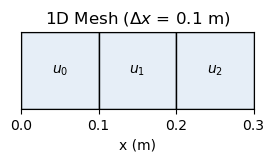

In [309]:
plot_mesh(0.1, 3,  display_fluxes = False, display_bc = False)

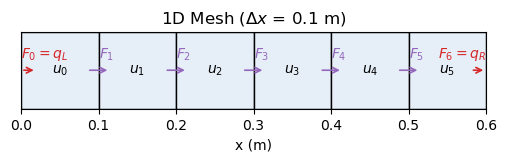

In [313]:
plot_mesh(0.1, 6, figsize=(6,1))

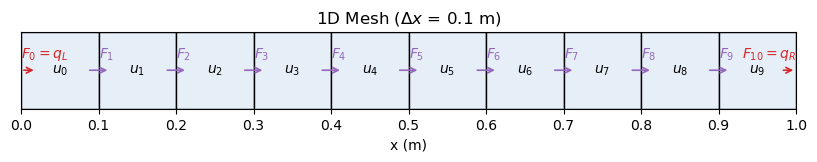

In [311]:
plot_mesh(0.1, 10)

In [53]:
def plot_temperature(u, dx):
    import matplotlib.pyplot as plt
    N = len(u)
    x_edges = [i * dx for i in range(N + 1)]
    y_edges = [0, 1]  # a thin strip to visualize 1D data as gridded cells
    C = [u]           # shape (1, N)

    fig, ax = plt.subplots(figsize=(8, 2))
    pc = ax.pcolormesh(x_edges, y_edges, C, shading='flat', cmap='viridis',
                       edgecolors='k', linewidth=0.5)
    ax.set_xlim(x_edges[0], x_edges[-1])
    ax.set_ylim(y_edges[0], y_edges[1])
    ax.set_yticks([])
    ax.set_xlabel('Position along the rod (x)')
    ax.set_title('Temperature distribution (gridded mesh)')
    fig.colorbar(pc, ax=ax, label='Temperature (u)')
    plt.show()

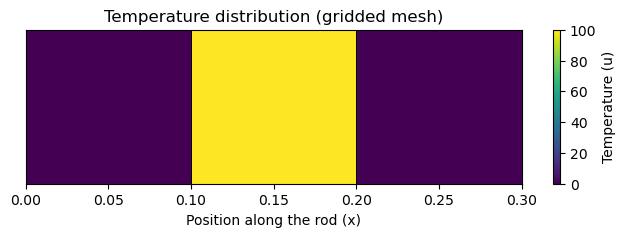

In [54]:
plot_temperature([0.0, 100.0, 0.0], dx=0.1)

## A 60-second z3py primer

### Variables:

In [83]:
from z3 import Bool, Int, Real, String

# Single variable declarations
p = Bool('p')
i = Int('i')
x = Real('x')
s = String('s')

from z3 import Bools, Ints, Reals, Strings

# Multiple variable declarations
p, q = Bools('p q')
i, j = Ints('i j')
x, y = Reals('x y')
s1, s2 = Strings('s1 s2')

Operations:

z3 is a **declarative** language. That means:
 - There are no assignments or state changes. 
 - Instead, you declare variables and state constraints on them.
 
 For example, the expression `x == 10` does not mean "set x to 10". It means "x is equal to 10".

In [86]:
x == 10

x == 10

In [88]:
y  == x + 5

y == x + 5

So, how do we reason about state changes in z3py? We do it by declaring new variables that represent the new state. For example, to represent a reassignment of `x`, we would declare a new variable `x'` (pronounced "x prime") and state the relationship between `x` and `x'`. 

```python
x = Int('x')      # Declare an integer variable x
x_prime = Int("x'")  # Declare a new integer variable x'
```

How do we actually *do* things in z3py? We use a `Solver` object to manage our constraints and check for satisfiability.

In [89]:
s = Solver()
s.add(x == 10)
s.add(y == x + 5)
s.check()

sat

In [90]:
def div(x: float, y: float) -> float:
    assert y != 0          # P
    res = x / y
    assert res * y == x    # Q  (idealized exact arithmetic)
    return res

In [108]:
def check_spec(spec):
    s = Solver()
    s.add(spec)
    if s.check() == sat:
        print("Specification is valid.")
    else:
        print("Specification is NOT valid.")

In [43]:
from z3 import Real, Solver, sat

spec= []

# Declare symbolic variables
x, y = Real('x'), Real('y')

# Preconditions
spec.append(y != 0)

# Code
res = x / y

# Postcondition
spec.append(res * y == x)

check_spec(spec)

TypeError: check_spec() missing 2 required positional arguments: 'code' and 'post'

In [1]:
from z3 import Real, Solver, sat
from z3 import FP, Float32

spec= []

# Declare symbolic variables
x = FP('x', Float32())
y = FP('y', Float32())

# Preconditions
spec.append(y != 0)

# Code
res = x / y

# Postcondition
spec.append(res * y == x)

check_spec(spec)

NameError: name 'check_spec' is not defined

In [17]:
from z3 import FP, Float32, Float64

In [25]:
x = FP('x', Float32())
y = FP('y', Float32())
res = FP('res', Float32())

res == x / y

In [39]:
def check(pre, code, post):
    from z3 import Solver, Not, And, sat
    s = Solver()
    s.add(And(pre))
    s.add(And(code))
    s.add(Not(And(post)))
    if s.check() == sat:
        print("Specification is NOT valid. Counterexample:")
        print(s.model())
    else:
        print("Specification is valid.")

In [47]:
x = FP('x', Float32())
y = FP('y', Float32())

check(
    (y != 0, x==x, y==y),
    res == x / y,
    res * y == x
)

Specification is NOT valid. Counterexample:
[x = 1.89798057079315185546875*(2**-79),
 y = 1.89404284954071044921875*(2**64)]


In [48]:
x = FP('x', Float32())
y = FP('y', Float32())

check(
    (y != 0, x==x, y==y, -30 < x, x < 30, -30 < y, y < 30),
    res == x / y,
    res * y == x
)

Specification is NOT valid. Counterexample:
[x = -1.63922965526580810546875*(2**4),
 y = -1.63300418853759765625*(2**-124)]


In [50]:
from z3 import FP, Float16

In [54]:
x = FP('x', Float16())
y = FP('y', Float16())
res = FP('res', Float16())

check(
    (y != 0, x==x, y==y, -30 < x, x < 30, -30 < y, y < 30),
    res == x / y,
    res * y == x
)

Specification is NOT valid. Counterexample:
[y = -0.0, x = +0.0, res = NaN]


In [ ]:
(0.0 / -0.0)

In [58]:
def check(pre=None, code=None, post=None, verbose=True):
    pre  = [] if pre  is None else ([pre]  if not isinstance(pre, (list, tuple)) else list(pre))
    code = [] if code is None else ([code] if not isinstance(code, (list, tuple)) else list(code))
    post = [] if post is None else ([post] if not isinstance(post, (list, tuple)) else list(post))
    s = Solver()
    s.add(And(pre + code))
    if post: s.add(Not(And(post)))   # refute the postcondition(s)
    res = s.check()
    if verbose:
        if res == sat:
            print("❌ NOT valid. Counterexample:\n", s.model())
        else:
            print("✅ Valid (unsat).")
    return res, (s.model() if res == sat else None)



In [61]:
def telescoping_check(N: int, verbose=True):
    """
    Prove: sum_i dudt[i]*dx == F[0] - F[N] for a 1-D FV divergence with N cells.
    """
    assert N >= 1
    dx  = Real('dx')
    F   = [Real(f'F{i}') for i in range(N+1)]   # faces 0..N
    dudt= [Real(f'd{i}') for i in range(N)]     # cells 0..N-1

    pre  = [dx > 0]
    code = [(dudt[i] == (F[i] - F[i+1]) / dx) for i in range(N)]
    post = [ (sum(dudt)*dx == (F[0] - F[-1])) ]

    return check(pre, code, post, verbose=verbose)

# examples:
telescoping_check(2)
telescoping_check(5)

✅ Valid (unsat).
✅ Valid (unsat).


(unsat, None)

In [63]:
def telescoping_check(N: int, verbose=True):
    """
    Prove: sum_i dudt[i]*dx == F[0] - F[N] for a 1-D FV divergence with N cells.
    """
    assert N >= 1
    dx  = Real('dx')
    F   = [Real(f'F{i}') for i in range(N+1)]   # faces 0..N
    dudt= [Real(f'd{i}') for i in range(N)]     # cells 0..N-1

    pre  = [dx > 0]
    code = [(dudt[i] == (F[i] - F[i+1]) / dx) for i in range(N)]
    post = [ (sum(dudt)*dx == (F[0] - F[-1])) ]

    return check(pre, code, post, verbose=verbose)

# examples:
telescoping_check(2)
telescoping_check(5)

✅ Valid (unsat).
✅ Valid (unsat).


(unsat, None)

In [93]:
def _divergence(c, f, dx):
    """Finite-volume divergence for N cells given face fluxes F (len=N+1)."""
    N = len(c)
    return [c[i] == (f[i] - f[i+1]) / dx for i in range(N)]


In [ ]:
def _diffusive_flux(f, c, kappa, dx):
    """Given a cell field (c), compute the diffusive flux (f)."""
    N = len(c)
    return [f[i] == -kappa * (c[i] - c[i-1]) / dx for i in range(1, N)]


In [88]:
def euler_step_constraints(u0, u1, dudt, dt):
    """Explicit Euler update: u^{n+1} = u^n + dt * dudt."""
    N = len(u0)
    return [u1[i] == u0[i] + dt * dudt[i] for i in range(N)]


In [89]:
def conservation_property(u0, u1, dx, dt, F):
    """Check conservation: Δ(sum(u)*dx) == dt*(F0 - FN)."""
    lhs = (sum(u1) - sum(u0)) * dx
    rhs = dt * (F[0] - F[-1])
    return lhs == rhs

In [90]:
u0 = [Real(f'u0_{i}') for i in range(3)]   # u at time n
u = [Real(f'u1_{i}') for i in range(3)]   # u at time n+1
d = [Real(f'd{i}') for i in range(3)]     # du/dt at time n
F = [Real(f'F{i}') for i in range(4)]     # flux
dx, dt, kappa = Real('dx'), Real('dt'), Real('kappa')

In [98]:
s = Solver()
s.add(dx > 0)#, dt > 0)#, kappa >= 0)

In [99]:
s.add(_divergence(d, F, dx))
s.add(flux_constraints(u0, F, kappa, dx))
s.add(euler_step_constraints(u0, u, d, dt))


In [100]:
s.check(Not(conservation_property(u0, u, dx, dt, F)))

unsat

In [101]:
s.model()

Z3Exception: model is not available